# Import Libraries

In [1]:
# Import the pandas library for data manipulation and analysis
import pandas as pd

c:\Users\PorallaPradhyumna\.conda\envs\env_rl\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\PorallaPradhyumna\.conda\envs\env_rl\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\PorallaPradhyumna\.conda\envs\env_rl\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Data Loading and Preprocessing

In [2]:
# This line specifies the file path of the current notebook.

fname = "D:/Programs/DeepLearing/Stock_prize_Prediction/Data/AAPL.csv"
# This line assigns the file path of the CSV file to the variable 'fname'.

with open(fname) as f:
    # This line opens the file specified by 'fname' in read mode and assigns it to the file object 'f'.
    
    data = f.read()
    # This line reads the contents of the file and assigns it to the variable 'data'.

lines = data.split("\n")
# This line splits the contents of the file into a list of lines using the newline character as the delimiter.

header = lines[0].split(",")
# This line splits the first line of the file (which contains the header) into a list of column names using the comma as the delimiter.

lines = lines[1:]
# This line removes the first line (header) from the list of lines.

print(header)
# This line prints the list of column names.

print(len(lines))
# This line prints the number of data rows in the file.


['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
1258


In [3]:
import numpy as np
AdjClose = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    AdjClose[i] = values[1]
    raw_data[i, :] = values[:]

In [4]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv(fname)

# Print the column names of the DataFrame
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [5]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
AdjClose = df['Adj Close']

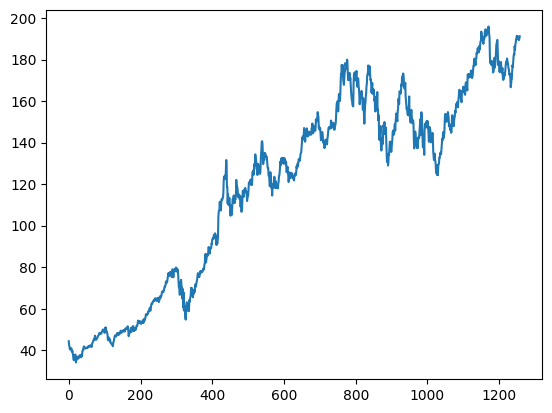

In [7]:
# Import the pyplot module from matplotlib
from matplotlib import pyplot as plt

# Plot the range of values against the AdjClose data
plt.plot(range(len(AdjClose)), AdjClose)
plt.tight_layout()

# Save the plot as a PDF file
plt.savefig('ADJ_CLOSE.pdf')
plt.show()

In [8]:
# Define the number of training samples as 50% of the total data samples
num_train_samples = int(0.5 * len(raw_data))

# Define the number of validation samples as 25% of the total data samples
num_val_samples = int(0.25 * len(raw_data))

# Calculate the number of test samples by subtracting the number of training and validation samples from the total data samples
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

# Print the number of training, validation, and test samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 629
num_val_samples: 314
num_test_samples: 315


In [9]:
# Calculate the mean of the raw data for the training samples
mean = raw_data[:num_train_samples].mean(axis=0)

# Subtract the mean from the raw data
raw_data -= mean

# Calculate the standard deviation of the raw data for the training samples
std = raw_data[:num_train_samples].std(axis=0)

# Divide the raw data by the standard deviation
raw_data /= std

In [10]:
raw_data.shape

(1258, 6)

In [11]:
from sklearn.preprocessing import StandardScaler

# Assuming 'y_test' is your target variable
scaler = StandardScaler()
y_test_scaled = scaler.fit_transform(AdjClose.to_numpy().reshape(-1, 1))

In [12]:
import keras
sampling_rate = 2
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=y_test_scaled[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=y_test_scaled[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=y_test_scaled[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)


In [13]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 6)
targets shape: (256, 1)


# Models and Analysis

## Dense Layers

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("v3_dense.tf",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("v3_dense.tf")



Epoch 1/10
2/2 [==============================] - 3s 752ms/step - loss: 1.2775 - mae: 0.9058 - val_loss: 5.0973 - val_mae: 2.2283
Epoch 2/10
2/2 [==============================] - 1s 688ms/step - loss: 2.0233 - mae: 1.1434 - val_loss: 1.5642 - val_mae: 1.1856
Epoch 3/10
2/2 [==============================] - 0s 398ms/step - loss: 0.5607 - mae: 0.6130 - val_loss: 0.1461 - val_mae: 0.2940
Epoch 4/10
2/2 [==============================] - 0s 44ms/step - loss: 0.2453 - mae: 0.4021 - val_loss: 0.1768 - val_mae: 0.3333
Epoch 5/10
2/2 [==============================] - 0s 44ms/step - loss: 0.1814 - mae: 0.3472 - val_loss: 0.3283 - val_mae: 0.4848
Epoch 6/10
2/2 [==============================] - 0s 42ms/step - loss: 0.1490 - mae: 0.3075 - val_loss: 0.3997 - val_mae: 0.5398
Epoch 7/10
2/2 [==============================] - 0s 43ms/step - loss: 0.1298 - mae: 0.2868 - val_loss: 0.6249 - val_mae: 0.7130
Epoch 8/10
2/2 [==============================] - 0s 39ms/step - loss: 0.1167 - mae: 0.2722 - 

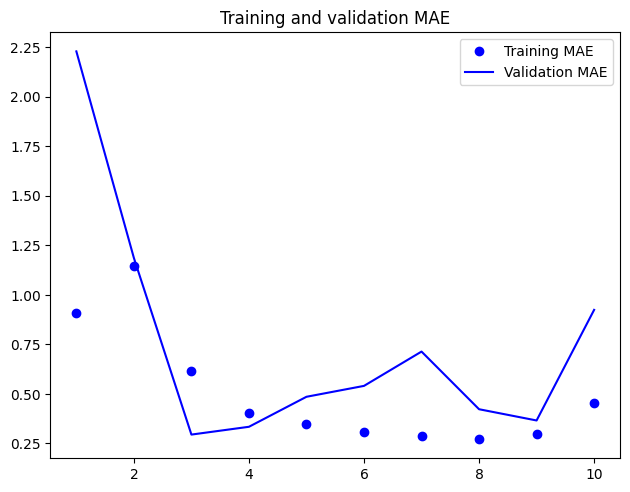

T-statistic: -1.1726536981541795
P-value: 0.26152430488324907
Fail to reject the null hypothesis. There is no significant difference between the distributions.


In [15]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.tight_layout()

# Save the plot as a PDF file
plt.savefig('Dense.pdf')
plt.title("Training and validation MAE")
plt.legend()
plt.show()

from scipy import stats


# Perform a t-test assuming unequal variances (Welch's t-test)
t_statistic, p_value = stats.ttest_ind(loss, val_loss, equal_var=False)

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the distributions.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the distributions.")


In [16]:

for samples, targets in test_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

In [17]:
(sequence_length, raw_data.shape[-1])

(120, 6)

In [18]:
output_seq_length = ((3 -  6+ 2 * 0) // 1) + 1
output_feature_channels = 8
print(output_seq_length)

-2


## Conv Layer

In [19]:
import keras
from keras import layers

# Define the model architecture
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Define callbacks, compile the model, and train
callbacks = [
    keras.callbacks.ModelCheckpoint("v3_conv.tf",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

# Load the saved model
model = keras.models.load_model("v3_conv.tf")




Epoch 1/10


2/2 [==============================] - ETA: 0s - loss: 0.3113 - mae: 0.3866

INFO:tensorflow:Assets written to: v3_conv.tf\assets


INFO:tensorflow:Assets written to: v3_conv.tf\assets


2/2 [==============================] - 8s 1s/step - loss: 0.3113 - mae: 0.3866 - val_loss: 0.1400 - val_mae: 0.3147
Epoch 2/10
1/2 [==============>...............] - ETA: 0s - loss: 0.0415 - mae: 0.1662

INFO:tensorflow:Assets written to: v3_conv.tf\assets


INFO:tensorflow:Assets written to: v3_conv.tf\assets


2/2 [==============================] - 1s 959ms/step - loss: 0.0395 - mae: 0.1636 - val_loss: 0.0534 - val_mae: 0.1919
Epoch 3/10
2/2 [==============================] - 0s 65ms/step - loss: 0.0285 - mae: 0.1384 - val_loss: 0.0587 - val_mae: 0.1988
Epoch 4/10
2/2 [==============================] - 0s 69ms/step - loss: 0.0269 - mae: 0.1316 - val_loss: 0.0794 - val_mae: 0.2293
Epoch 5/10
2/2 [==============================] - 0s 53ms/step - loss: 0.0245 - mae: 0.1251 - val_loss: 0.0690 - val_mae: 0.2143
Epoch 6/10
2/2 [==============================] - 0s 51ms/step - loss: 0.0278 - mae: 0.1311 - val_loss: 0.0573 - val_mae: 0.1969
Epoch 7/10
2/2 [==============================] - 0s 55ms/step - loss: 0.0246 - mae: 0.1241 - val_loss: 0.0552 - val_mae: 0.1942
Epoch 8/10
2/2 [==============================] - 0s 68ms/step - loss: 0.0227 - mae: 0.1191 - val_loss: 0.0570 - val_mae: 0.1966
Epoch 9/10
2/2 [==============================] - 0s 54ms/step - loss: 0.0235 - mae: 0.1219 - val_loss: 0.0

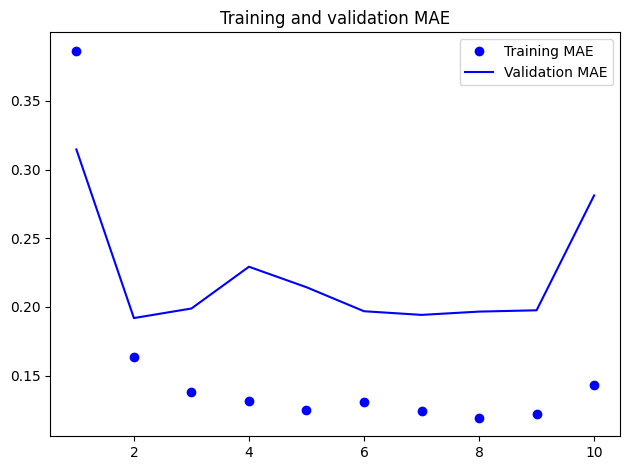

T-statistic: -2.174700558902556
P-value: 0.04783330632147114
Reject the null hypothesis. There is a significant difference between the distributions.


In [20]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.tight_layout()

# Save the plot as a PDF file
plt.savefig('CONV.pdf')
plt.legend()
plt.show()

from scipy import stats


# Perform a t-test assuming unequal variances (Welch's t-test)
t_statistic, p_value = stats.ttest_ind(loss, val_loss, equal_var=False)

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the distributions.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the distributions.")


## LSTM's

In [21]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("v3_lstm.tf",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("v3_lstm.tf")

Epoch 1/10
1/2 [==============>...............] - ETA: 2s - loss: 0.4029 - mae: 0.5086

INFO:tensorflow:Assets written to: v3_lstm.tf\assets


INFO:tensorflow:Assets written to: v3_lstm.tf\assets


2/2 [==============================] - 6s 4s/step - loss: 0.3961 - mae: 0.4991 - val_loss: 0.5576 - val_mae: 0.7195
Epoch 2/10
1/2 [==============>...............] - ETA: 0s - loss: 0.2999 - mae: 0.4055

INFO:tensorflow:Assets written to: v3_lstm.tf\assets


INFO:tensorflow:Assets written to: v3_lstm.tf\assets


2/2 [==============================] - 3s 3s/step - loss: 0.3033 - mae: 0.4146 - val_loss: 0.4409 - val_mae: 0.6319
Epoch 3/10
1/2 [==============>...............] - ETA: 0s - loss: 0.2700 - mae: 0.3869

INFO:tensorflow:Assets written to: v3_lstm.tf\assets


INFO:tensorflow:Assets written to: v3_lstm.tf\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2640 - mae: 0.3825 - val_loss: 0.3728 - val_mae: 0.5746
Epoch 4/10
1/2 [==============>...............] - ETA: 0s - loss: 0.2347 - mae: 0.3593

INFO:tensorflow:Assets written to: v3_lstm.tf\assets


INFO:tensorflow:Assets written to: v3_lstm.tf\assets


2/2 [==============================] - 4s 4s/step - loss: 0.2359 - mae: 0.3635 - val_loss: 0.3600 - val_mae: 0.5631
Epoch 5/10
1/2 [==============>...............] - ETA: 0s - loss: 0.2231 - mae: 0.3563

INFO:tensorflow:Assets written to: v3_lstm.tf\assets


INFO:tensorflow:Assets written to: v3_lstm.tf\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2130 - mae: 0.3451 - val_loss: 0.3409 - val_mae: 0.5457
Epoch 6/10
1/2 [==============>...............] - ETA: 0s - loss: 0.1941 - mae: 0.3258

INFO:tensorflow:Assets written to: v3_lstm.tf\assets


INFO:tensorflow:Assets written to: v3_lstm.tf\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1936 - mae: 0.3299 - val_loss: 0.3137 - val_mae: 0.5198
Epoch 7/10
1/2 [==============>...............] - ETA: 0s - loss: 0.1848 - mae: 0.3250

INFO:tensorflow:Assets written to: v3_lstm.tf\assets


INFO:tensorflow:Assets written to: v3_lstm.tf\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1758 - mae: 0.3164 - val_loss: 0.3088 - val_mae: 0.5149
Epoch 8/10
2/2 [==============================] - 0s 70ms/step - loss: 0.1592 - mae: 0.3015 - val_loss: 0.3217 - val_mae: 0.5275
Epoch 9/10
2/2 [==============================] - 0s 92ms/step - loss: 0.1433 - mae: 0.2859 - val_loss: 0.3157 - val_mae: 0.5216
Epoch 10/10
2/2 [==============================] - 0s 83ms/step - loss: 0.1295 - mae: 0.2721 - val_loss: 0.3226 - val_mae: 0.5281


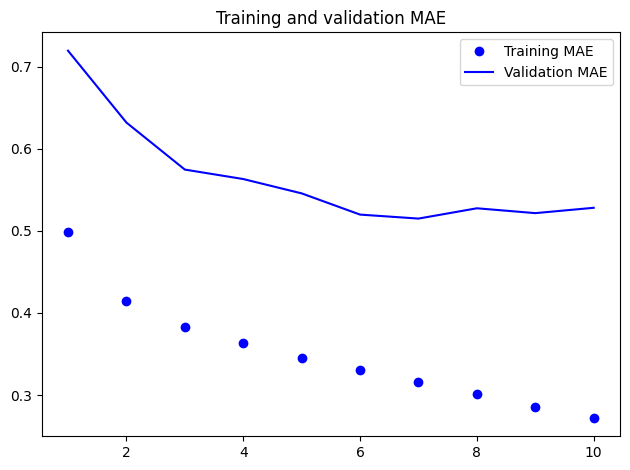

T-statistic: -7.178029806956321
P-value: 1.1212554205261695e-06
Reject the null hypothesis. There is a significant difference between the distributions.


In [22]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.tight_layout()

# Save the plot as a PDF file
plt.savefig('LSTM.pdf')
plt.legend()
plt.show()

from scipy import stats


# Perform a t-test assuming unequal variances (Welch's t-test)
t_statistic, p_value = stats.ttest_ind(loss, val_loss, equal_var=False)

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the distributions.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the distributions.")


In [23]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

In [24]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

In [25]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


In [26]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


In [27]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## LSTM with Dropout

In [28]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("v3_lstm_dropout.tf",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
2/2 [==============================] - ETA: 0s - loss: 0.3615 - mae: 0.4893INFO:tensorflow:Assets written to: v3_lstm_dropout.tf\assets


INFO:tensorflow:Assets written to: v3_lstm_dropout.tf\assets


2/2 [==============================] - 6s 4s/step - loss: 0.3615 - mae: 0.4893 - val_loss: 0.2753 - val_mae: 0.4752
Epoch 2/10
2/2 [==============================] - 1s 657ms/step - loss: 0.2818 - mae: 0.4209 - val_loss: 0.3262 - val_mae: 0.5253
Epoch 3/10
2/2 [==============================] - ETA: 0s - loss: 0.2498 - mae: 0.3950INFO:tensorflow:Assets written to: v3_lstm_dropout.tf\assets


INFO:tensorflow:Assets written to: v3_lstm_dropout.tf\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2498 - mae: 0.3950 - val_loss: 0.2173 - val_mae: 0.4073
Epoch 4/10
2/2 [==============================] - 2s 931ms/step - loss: 0.2073 - mae: 0.3615 - val_loss: 0.2974 - val_mae: 0.4971
Epoch 5/10
2/2 [==============================] - 2s 863ms/step - loss: 0.1678 - mae: 0.3236 - val_loss: 0.2232 - val_mae: 0.4152
Epoch 6/10
2/2 [==============================] - 1s 741ms/step - loss: 0.1447 - mae: 0.3008 - val_loss: 0.3945 - val_mae: 0.5862
Epoch 7/10
2/2 [==============================] - ETA: 0s - loss: 0.1322 - mae: 0.2905INFO:tensorflow:Assets written to: v3_lstm_dropout.tf\assets


INFO:tensorflow:Assets written to: v3_lstm_dropout.tf\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1322 - mae: 0.2905 - val_loss: 0.1823 - val_mae: 0.3620
Epoch 8/10
2/2 [==============================] - 1s 669ms/step - loss: 0.1270 - mae: 0.2870 - val_loss: 0.2516 - val_mae: 0.4466
Epoch 9/10
2/2 [==============================] - 1s 640ms/step - loss: 0.1145 - mae: 0.2704 - val_loss: 0.2714 - val_mae: 0.4685
Epoch 10/10
2/2 [==============================] - 1s 752ms/step - loss: 0.0985 - mae: 0.2477 - val_loss: 0.2614 - val_mae: 0.4571


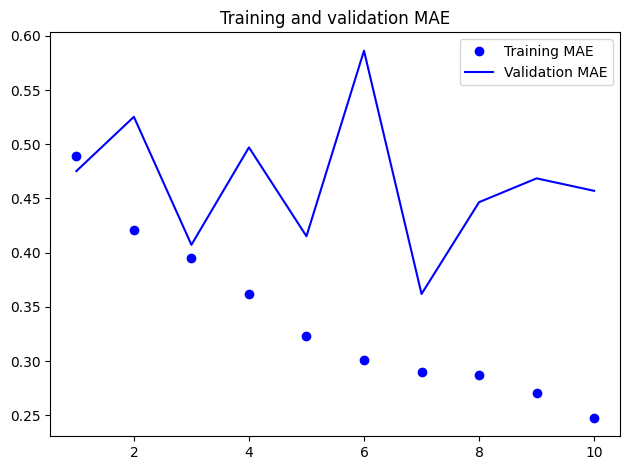

T-statistic: -3.9861607622022572
P-value: 0.0009171180253584644
Reject the null hypothesis. There is a significant difference between the distributions.


In [29]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.tight_layout()

# Save the plot as a PDF file
plt.savefig('LSTM_DROP.pdf')
plt.legend()
plt.show()

from scipy import stats


# Perform a t-test assuming unequal variances (Welch's t-test)
t_statistic, p_value = stats.ttest_ind(loss, val_loss, equal_var=False)

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the distributions.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the distributions.")


In [30]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)


## GRU

In [31]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("v3_stacked_gru_dropout.tf",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("v3_stacked_gru_dropout.tf")
#print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
2/2 [==============================] - ETA: 0s - loss: 0.6257 - mae: 0.6564INFO:tensorflow:Assets written to: v3_stacked_gru_dropout.tf\assets


INFO:tensorflow:Assets written to: v3_stacked_gru_dropout.tf\assets


2/2 [==============================] - 13s 7s/step - loss: 0.6257 - mae: 0.6564 - val_loss: 0.2146 - val_mae: 0.3906
Epoch 2/10
2/2 [==============================] - ETA: 0s - loss: 0.3124 - mae: 0.4479INFO:tensorflow:Assets written to: v3_stacked_gru_dropout.tf\assets


INFO:tensorflow:Assets written to: v3_stacked_gru_dropout.tf\assets


2/2 [==============================] - 10s 8s/step - loss: 0.3124 - mae: 0.4479 - val_loss: 0.1380 - val_mae: 0.3050
Epoch 3/10
2/2 [==============================] - 3s 1s/step - loss: 0.2451 - mae: 0.3944 - val_loss: 0.1720 - val_mae: 0.3387
Epoch 4/10
2/2 [==============================] - 3s 1s/step - loss: 0.2077 - mae: 0.3573 - val_loss: 0.1515 - val_mae: 0.3193
Epoch 5/10
2/2 [==============================] - ETA: 0s - loss: 0.1799 - mae: 0.3343INFO:tensorflow:Assets written to: v3_stacked_gru_dropout.tf\assets


INFO:tensorflow:Assets written to: v3_stacked_gru_dropout.tf\assets


2/2 [==============================] - 8s 7s/step - loss: 0.1799 - mae: 0.3343 - val_loss: 0.1370 - val_mae: 0.3062
Epoch 6/10
2/2 [==============================] - 3s 1s/step - loss: 0.1636 - mae: 0.3269 - val_loss: 0.2185 - val_mae: 0.3861
Epoch 7/10
2/2 [==============================] - 2s 1s/step - loss: 0.1405 - mae: 0.3033 - val_loss: 0.1443 - val_mae: 0.3136
Epoch 8/10
2/2 [==============================] - ETA: 0s - loss: 0.1413 - mae: 0.2982INFO:tensorflow:Assets written to: v3_stacked_gru_dropout.tf\assets


INFO:tensorflow:Assets written to: v3_stacked_gru_dropout.tf\assets


2/2 [==============================] - 7s 6s/step - loss: 0.1413 - mae: 0.2982 - val_loss: 0.1288 - val_mae: 0.3009
Epoch 9/10
2/2 [==============================] - ETA: 0s - loss: 0.1189 - mae: 0.2794INFO:tensorflow:Assets written to: v3_stacked_gru_dropout.tf\assets


INFO:tensorflow:Assets written to: v3_stacked_gru_dropout.tf\assets


2/2 [==============================] - 7s 5s/step - loss: 0.1189 - mae: 0.2794 - val_loss: 0.1285 - val_mae: 0.3008
Epoch 10/10
2/2 [==============================] - 3s 1s/step - loss: 0.1193 - mae: 0.2759 - val_loss: 0.2244 - val_mae: 0.3927


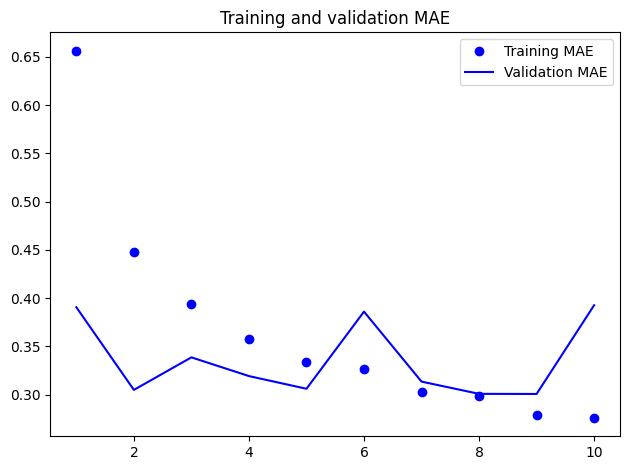

T-statistic: 0.8356023900019022
P-value: 0.4210493971502789
Fail to reject the null hypothesis. There is no significant difference between the distributions.


In [32]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.tight_layout()

# Save the plot as a PDF file
plt.savefig('GRU.pdf')
plt.legend()
plt.show()

from scipy import stats


# Perform a t-test assuming unequal variances (Welch's t-test)
t_statistic, p_value = stats.ttest_ind(loss, val_loss, equal_var=False)

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the distributions.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the distributions.")
